In [16]:
 # from model import ToyNet, UNet
from model.utils import timestep_embedding, timesteps_to_tensor
import torch.nn.functional as F

from diffusion import DiffusionProcess
import torch
from diffusion.utils.sde import SDE
import numpy as np
import logging

from pytorch_lightning import LightningDataModule
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import gridspec
import torch.nn as nn
from torch.distributions import Normal, Categorical, MixtureSameFamily
import torch
#device = 'mps'
device = 'cuda:0'
import random
from src.PCF_with_empirical_measure import PCF_with_empirical_measure

In [2]:
class ResNet_FC(nn.Module):
    def __init__(self, data_dim, hidden_dim, num_res_blocks):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.map=nn.Linear(data_dim, hidden_dim)
        self.res_blocks = nn.ModuleList(
            [self.build_res_block() for _ in range(num_res_blocks)])

    def build_linear(self, in_features, out_features):
        linear = nn.Linear(in_features, out_features)
        return linear

    def build_res_block(self):
        hid = self.hidden_dim
        layers = []
        widths =[hid]*4
        for i in range(len(widths) - 1):
            layers.append(self.build_linear(widths[i], widths[i + 1]))
            layers.append(nn.SiLU())
        return nn.Sequential(*layers)

    def forward(self, x):
        h=self.map(x)
        for res_block in self.res_blocks:
            h = (h + res_block(h)) / np.sqrt(2)
        return h

In [3]:
class ToyNet(nn.Module):
    def __init__(self, data_dim, direction=None):
        super(ToyNet, self).__init__()
        self.direction = direction

        self.time_embed_dim = 128
        dim = 256
        out_dim = data_dim

        self.t_module = nn.Sequential(nn.Linear(self.time_embed_dim, dim), nn.SiLU(), nn.Linear(dim, dim),)
        self.x_module = ResNet_FC(data_dim, dim, num_res_blocks=1)
        self.out_module = nn.Sequential(nn.Linear(dim,dim), nn.SiLU(), nn.Linear(dim, out_dim),)
        
    def forward(self, x, t: int or list[int]):
        t = timesteps_to_tensor(t, batch_size=x.shape[0]).to(x.device)
        t_emb = timestep_embedding(t, self.time_embed_dim)

        t_out = self.t_module(t_emb)
        x_out = self.x_module(x)
        out   = self.out_module(x_out+t_out)

        return out

In [4]:
# Data distribution
mix = Categorical(torch.ones(2,))
comp = Normal(torch.tensor([0 - 2., 0 + 2.]), torch.tensor([.5, .5]))
#comp = Normal(torch.tensor([0 - 2/3., 0 + 2/3.]), torch.tensor([.5/3, .5/3]))
data_dist = MixtureSameFamily(mix, comp)


In [5]:
class SDEProcess(DiffusionProcess):
    def __init__(self, sde_type="VP",
                 sde_info={"VP": {"beta_min": 0.1, "beta_max": 20},
                           "subVP": {"beta_min": 0.1, "beta_max": 20},
                           "VE": {"sigma_min": 0.01, "sigma_max": 50}}, 
                 **kwargs):
        super(SDEProcess, self).__init__(**kwargs)
        assert self.discrete is False, "DDPM is only for continuous data"
        self.dt = 1. / self.total_steps # step size
        self.sde = SDE(self.total_steps, sde_type, sde_info)
        
    def forward_one_step(self, x_prev, t):
        """
        Discretized forward SDE process for actual compuatation: 
        x_{t+1} = x_t + f_t(x_t) * dt + G_t * z_t * sqrt(dt)
        """
        f_t, g_t = self.sde.drifts(x_prev, t-1)
        z = torch.randn_like(x_prev)
        x_t = x_prev + f_t * self.dt + g_t * z * np.sqrt(self.dt)
        return x_t

    
    def backward_one_step(self, x_t, t, pred_score, clip_denoised=True):
        """
        Discretized backward SDE process for actual compuatation:
        x_{t-1} = x_t - (f_t(x_t) - (G_t)^2 * pred_score) * dt + G_t * z_t * sqrt(dt)
        """
        z = torch.randn_like(x_t).to(device)
        f_t, g_t = self.sde.drifts(x_t, t)
        f_t = f_t.to(device)
        x_prev = x_t - (f_t - g_t**2 * pred_score) * self.dt + g_t * z * np.sqrt(self.dt)
        if clip_denoised and x_t.ndim > 2:
            print('backward_one_step')
            x_prev.clamp_(-1., 1.)

        return x_prev

    @torch.no_grad()
    def sample(self, noise, net):
        """
        Sample from backward diffusion process
        """
        x_t = noise
        trajs = [x_t]

        for t in reversed(range(1, self.total_steps+1)):
            pred_score = net(x_t, t)
            x_t = self.backward_one_step(x_t, t, pred_score)
            trajs.append(x_t)
        return x_t, torch.hstack(trajs)
    
    def forward_sample(self, data):
        trajs = torch.zeros([len(data), self.total_steps+1])
        x = data.to(device)
        trajs[:, 0] = x
        for t in range(1, self.total_steps+1):
            x = self.forward_one_step(x, t)
            trajs[:, t] = x
        return x, trajs
    
    def backward_sample(self, noise, net):
        """
        Sample from backward diffusion process
        """
        x_t = noise
        trajs = [x_t]

        for t in reversed(range(1, self.total_steps+1)):
            pred_score = net(x_t, t)
            x_t = self.backward_one_step(x_t, t, pred_score)
            trajs.append(x_t)
        return x_t, torch.hstack(trajs)


In [6]:
score_net = ToyNet(data_dim=1).to(device)
total_steps = 100
num_paths = 32
diffusion = SDEProcess(discrete=False, total_steps=total_steps, sde_type="VP")

In [7]:
x_gen, traj_back = diffusion.sample(torch.randn([num_paths, 1]).to(device), score_net)


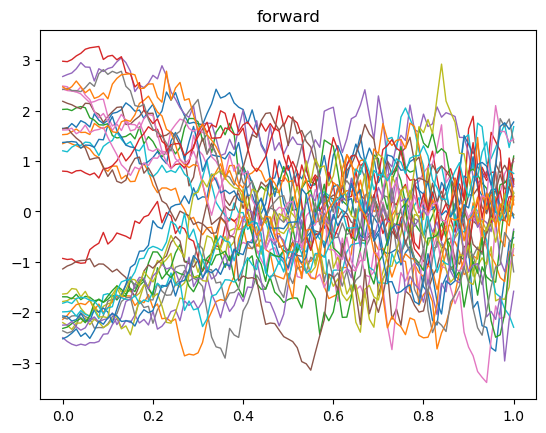

In [8]:
x_data_test = data_dist.sample([num_paths])
x_noise_test, traj_forward_test = diffusion.forward_sample(x_data_test)

xxx = np.linspace(0, 1, traj_forward_test.shape[1])
for line in traj_forward_test:
    plt.plot(xxx, line, linewidth=1.0)
    plt.title('forward')

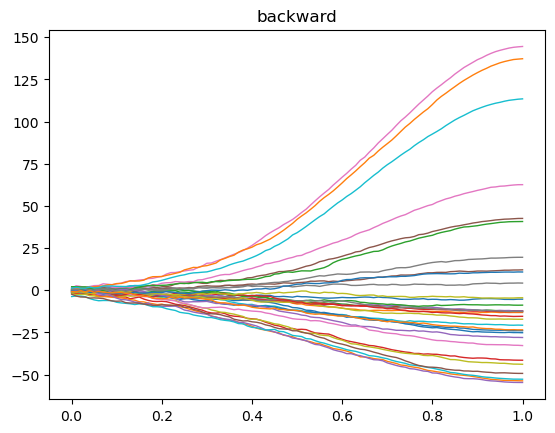

In [9]:
x_gen, traj_back = diffusion.sample(torch.randn([num_paths, 1]).to(device), score_net)
xxx = np.linspace(0, 1, traj_forward_test.shape[1])
for line in traj_back:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('backward')

Train the network with PCF distance and reconstrucion loss. 

I haven't add time dimension to the input so far in this implementation bacause it doesn't work well now. If anyone wants to add time dimension, just replace pcf = PCF_with_empirical_measure(16, 12, 1) with pcf = PCF_with_empirical_measure(16, 12, 1, add_time=True) in belowing code cell.

Current implementation is not stable. Sometimes you may not get the backward figure as I show below. In this case, training extra 50 or 100 epoches may bring the similar result.  Anyway, I will keep working on it. 

In [10]:
def loss_function(x0, diffusion_process, score_net, t):
    #f_t is not involved in the score matching loss soe input zeros for the 1st argument.
    #
    _, g_t = diffusion_process.sde.drifts(torch.zeros_like(x0), t)
    
    # Eq 29 in Score based diffusion model (Yang Song 2021 ICLR)
    mean, std = diffusion_process.sde.perturbation_kernel(x0, t)
    z = torch.randn_like(x0)

    x_t = mean + std * z  # x_t is perturbed x_0
    pred_score = score_net(x_t, t)
    target = -z / std   # Since desired derivative of the given kernel is - (x_t - mean) / std^2
    loss = g_t**2 * F.mse_loss(pred_score, target, reduction="sum") / np.prod(x0.size())
    return loss

In [11]:
x_data = data_dist.sample([num_paths]).to(device)
x_noise, traj_forward = diffusion.forward_sample(x_data)

# SDE-based diffusion models

In [12]:
num_epochs = 250
opt = torch.optim.Adam(score_net.parameters(), lr=1e-3)

for i in range(num_epochs):
    # Forward process to generate time series
    opt.zero_grad()
    x0 = data_dist.sample([num_paths]).to(device)
    t = np.random.randint(1, total_steps + 1)
    loss = loss_function(x0.view(-1 ,1), diffusion, score_net, t)
    loss.backward()
    opt.step()
    if(i%50==0):
        print(i, loss)

0 tensor(18.9516, device='cuda:0', grad_fn=<DivBackward0>)
50 tensor(1.0518, device='cuda:0', grad_fn=<DivBackward0>)
100 tensor(2.3742, device='cuda:0', grad_fn=<DivBackward0>)
150 tensor(0.9026, device='cuda:0', grad_fn=<DivBackward0>)
200 tensor(6.9607, device='cuda:0', grad_fn=<DivBackward0>)


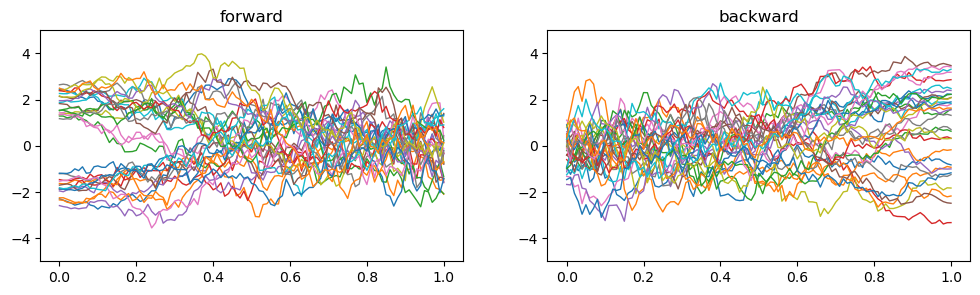

In [14]:
xxx = np.linspace(0, 1, traj_forward.shape[1])

plt.figure(figsize=(12,3))

plt.subplot(1, 2, 1)
for line in traj_forward:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('forward')
plt.ylim(-5, 5)
    
plt.subplot(1, 2, 2)
x_gen, traj_back = diffusion.sample(torch.randn([num_paths, 1]).to(device), score_net)


for line in traj_back:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('backward')
plt.ylim(-5, 5)

plt.show()

# Reconstruction-loss based diffusion models

In [ ]:
from src.PCF_with_empirical_measure import PCF_with_empirical_measure

pcf = PCF_with_empirical_measure(30, 12, 1)
pcf = pcf.to(device)

num_epochs = 200
opt = torch.optim.Adam(score_net.parameters(), lr=1e-3)

for i in range(num_epochs):

    opt.zero_grad()
    x_data = data_dist.sample([num_paths])
    x_noise, traj_forward = diffusion.forward_sample(x_data)
    traj_forward = traj_forward.to(device)
    # Backward process to generate time series
    x_data1 = data_dist.sample([num_paths])
    x_noise1, traj_forward1 = diffusion.forward_sample(x_data1)
    
    x_gen, traj_back = diffusion.backward_sample(torch.randn([num_paths, 1]).to(device), score_net)
    x_gen1, traj_back1 = diffusion.backward_sample(traj_forward[:,-1].unsqueeze(1).to(device), score_net) 
    traj_back_flip = torch.fliplr(traj_back)
    traj_back_flip1 = torch.fliplr(traj_back1)
    loss = (pcf.distance_measure(traj_forward.view([-1, total_steps+1, 1]), traj_back_flip.view([-1, total_steps+1, 1]), Lambda=1.0)
                        + torch.mean(((traj_forward - traj_back_flip1)**2).reshape(traj_back.shape[0], -1), dim=(0,1)))
    loss.backward()
    opt.step()
    print(i, loss)

In [ ]:
x_gen, traj_back = diffusion.sample(torch.randn([num_paths, 1]).cuda(), score_net)
xxx = np.linspace(0, 1, traj_forward.shape[1])
for line in traj_back:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('backward')

Train the model only using reconstruction loss. It doesn't give a good result. Can find a better loss to replace reconstrcton loss. After I find a better loss, combining PCF loss with another better loss should bring better and more stable results. 

In [ ]:
num_epochs = 200
opt = torch.optim.Adam(score_net.parameters(), lr=1e-3)
for i in range(num_epochs):
    # Forward process to generate time series
    opt.zero_grad()
    x_data = data_dist.sample([num_paths])
    x_noise, traj_forward = diffusion.forward_sample(x_data)
    traj_forward = traj_forward.to(device)
    # Backward process to generate time series
    x_gen1, traj_back1 = diffusion.backward_sample(traj_forward[:,-1].unsqueeze(1).to(device), score_net) 
    traj_back_flip1 = torch.fliplr(traj_back1)
    loss = (torch.mean(((traj_forward - traj_back_flip1)**2).reshape(traj_back_flip1.shape[0], -1), dim=(0,1)))
    loss.backward()
    opt.step()
    print(i, loss)

In [ ]:
x_gen, traj_back = diffusion.sample(torch.randn([num_paths, 1]).cuda(), score_net)
xxx = np.linspace(0, 1, traj_forward.shape[1])
for line in traj_back:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('backward')

In [ ]:
x_gen, traj_back = diffusion.sample(torch.randn([num_paths, 1]).cuda(), score_net)
xxx = np.linspace(0, 1, traj_forward.shape[1])
for line in traj_back:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('backward')

Train the model only using PCF loss. 

(So far I don't get a good result after adding time dimension.) 



In [ ]:
pcf = PCF_with_empirical_measure(16, 12, 1, add_time= True)
pcf = pcf.to(device)
num_epochs = 100
for i in range(num_epochs):
    if i>500:
        G_opt = torch.optim.Adam(score_net.parameters(), lr=5e-4)
        D_opt = torch.optim.Adam(pcf.parameters(), lr=5e-4)
    elif i>800:
        G_opt = torch.optim.Adam(score_net.parameters(), lr=1e-4)
        D_opt = torch.optim.Adam(pcf.parameters(), lr=1e-4)
    x_data = data_dist.sample([num_paths])
    x_noise, traj_forward = diffusion.forward_sample(x_data)
    traj_forward = traj_forward.to(device)
        
    
    # train the PCF network as a discriminator. We want PCF has a great ablitily to distinguish the real data and the generated data. 
    # So we train the PCF to maxmise the distance between the real data and the generated data.
    with torch.no_grad():
        x_gen, traj_back = diffusion.backward_sample(torch.cat((torch.randn([num_paths, 1]).to(device), traj_forward[:,-1].unsqueeze(1)),0), score_net)
        traj_forward_flip = torch.fliplr(traj_forward)
        traj_forward_flip_cat = torch.cat((traj_forward_flip.view([-1, total_steps+1, 1]),traj_forward_flip.view([-1, total_steps+1, 1])),0)

    pcf.train()
    D_loss = -pcf.distance_measure(traj_forward_flip_cat, traj_back.view([-1, total_steps+1, 1]), Lambda=1.0)

    D_opt.zero_grad()
    D_loss.backward()
    D_opt.step()
   
    # train the score network to minmise the distance between the real data and the generated data
    x_gen, traj_back = diffusion.backward_sample(torch.cat((torch.randn([num_paths, 1]).to(device), traj_forward[:,-1].unsqueeze(1)),0).to(device), score_net)
    x_gen1, traj_back1 = x_gen[num_paths:], traj_back[num_paths:]
    traj_back_flip1 = torch.fliplr(traj_back1)
    pcf.eval()
    
    G_loss =  pcf.distance_measure(traj_forward_flip_cat, traj_back.view([-1, total_steps+1, 1]), Lambda=1.0) + \
        0.5*torch.mean(((traj_forward - traj_back_flip1)**2).reshape(traj_forward.shape[0], -1), dim=(0,1))

    G_opt.zero_grad()
    G_loss.backward()
    G_opt.step()

    print(i, D_loss.item() , G_loss.item())

In [ ]:


pcf = PCF_with_empirical_measure(16, 12, 1, add_time=True)
pcf = pcf.to(device)

num_epochs = 1
opt = torch.optim.Adam(score_net.parameters(), lr=1e-3)
for i in range(num_epochs):
    # Forward process to generate time series
    opt.zero_grad()
    x_data = data_dist.sample([num_paths])
    x_noise, traj_forward = diffusion.forward_sample(x_data)
    traj_forward = traj_forward.to(device)
    # Backward process to generate time series
    x_gen, traj_back = diffusion.backward_sample(torch.randn([num_paths, 1]).to(device), score_net)
    traj_back_flip = torch.fliplr(traj_back)
    traj_forward_flip = torch.fliplr(traj_forward)
    loss = pcf.distance_measure(traj_forward_flip.view([-1, total_steps+1, 1]), 
                                traj_back.view([-1, total_steps+1, 1]), Lambda=0.01) 

    loss.backward()
    opt.step()
    print(i, loss)

In [ ]:
x_gen, traj_back = diffusion.sample(torch.randn([50, 1]).cuda(), score_net)
xxx = np.linspace(0, 1, traj_forward.shape[1])
for line in traj_back:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('backward')

In [ ]:
x_gen, traj_back = diffusion.sample(torch.randn([500, 1]).cuda(), score_net)
plt.hist(x_gen[:, 0].cpu(), bins = 50, density=True)


In [ ]:
plt.hist(x_data_test.cpu(), bins = 50, density=True)

In [ ]:
x_gen[0]

In [ ]:
print(x_gen[:, 0])

In [ ]:
print(pcf.parameters())

In [ ]:
print(traj_forward.shape)
print(traj_back.shape)

In [ ]:
print(traj_forward_flip[:, [0, 101]].view([-1, 2, 1]).shape)

In [ ]:
def mask_time(a):
    b = a[::2, :]
    return b

a = torch.randn([100, 1])
b = mask_time(a)
print(a)
print(b)
              

# PCFD only distance

tensor([[ 2.7078,  2.7078,  2.7102,  2.7102,  2.6599,  2.6599,  2.6431,  2.6431,
          2.6722,  2.6722,  2.5648,  2.5648,  2.6168,  2.6168,  2.6184,  2.6184,
          2.7127,  2.7127,  2.6953,  2.6953,  2.5499,  2.5499,  2.6046,  2.6046,
          2.8713,  2.8713,  2.9037,  2.9037,  2.9492,  2.9492,  2.8842,  2.8842,
          2.8034,  2.8034,  2.7454,  2.7454,  2.6295,  2.6295,  2.5079,  2.5079,
          2.3754,  2.3754,  2.4437,  2.4437,  2.2774,  2.2774,  2.2942,  2.2942,
          2.2374,  2.2374,  2.0639,  2.0639,  1.7307,  1.7307,  1.6701,  1.6701,
          1.5187,  1.5187,  1.5905,  1.5905,  1.7017,  1.7017,  1.4507,  1.4507,
          1.2297,  1.2297,  1.2729,  1.2729,  1.3607,  1.3607,  1.0580,  1.0580,
          0.6429,  0.6429,  0.6543,  0.6543,  1.0375,  1.0375,  1.1992,  1.1992,
          1.0654,  1.0654,  1.4538,  1.4538,  1.1754,  1.1754,  0.9758,  0.9758,
          0.8076,  0.8076,  0.8524,  0.8524,  1.0838,  1.0838,  1.6318,  1.6318,
          1.5390,  1.5390,  

In [30]:
pcf = PCF_with_empirical_measure(16, 10, 1, add_time=False)
pcf = pcf.to(device)
num_paths = 64
G_opt = torch.optim.Adam(score_net.parameters(), lr=1e-4, betas=(0.9, 0.999))
D_opt = torch.optim.Adam(pcf.parameters(), lr=5e-3, betas=(0.9, 0.999))
n_Gstep_per_Dstep = 20
num_epochs = 50
for i in range(num_epochs):
    x_data = data_dist.sample([num_paths])
    x_noise, traj_forward = diffusion.forward_sample(x_data)
    traj_forward = traj_forward.to(device)
    traj_forward_flip = torch.fliplr(traj_forward)
             
    # train the PCF network as a discriminator. We want PCF has a great ablitily to distinguish the real data and the generated data. 
    # So we train the PCF to maxmise the distance between the real data and the generated data.
    with torch.no_grad():
        x_gen, traj_back = diffusion.backward_sample(torch.randn([num_paths, 1]).to(device), score_net)
        
        
    pcf.train()
    D_loss = -pcf.distance_measure(traj_forward_flip.view([-1, total_steps+1, 1]), 
                                traj_back.view([-1, total_steps+1, 1]), Lambda=0.0) 

    D_opt.zero_grad()
    D_loss.backward()
    D_opt.step()
    pcf.eval()

    for j in range(n_Gstep_per_Dstep):
        with torch.no_grad():
            x_data = data_dist.sample([num_paths])
            x_noise, traj_forward = diffusion.forward_sample(x_data)
            traj_forward = traj_forward.to(device)
            x_gen, traj_back = diffusion.backward_sample(torch.randn([num_paths, 1]).to(device), score_net) 
        traj_forward_flip = torch.fliplr(traj_forward)
        G_loss =  pcf.distance_measure(traj_forward_flip.view([-1, total_steps+1, 1]), 
                                traj_back.view([-1, total_steps+1, 1]), Lambda=0) 
        G_opt.zero_grad()
        G_loss.backward()
        G_opt.step()
        pcf.eval()
        print(j, G_loss.item())
    
    print(i, D_loss.item(), G_loss.item())

0 1.6117066144943237
1 1.2339879274368286
2 0.7661504745483398
3 1.1573469638824463
4 1.8058290481567383
5 0.7614613771438599
6 0.8027796149253845
7 1.6266186237335205
8 1.3374769687652588
9 1.9333515167236328
10 1.616500973701477
11 1.1393675804138184
12 0.7973389625549316
13 1.2231791019439697
14 1.1087721586227417
15 0.9749274253845215
16 1.7514808177947998
17 1.3773713111877441
18 0.9885991811752319
19 1.8428105115890503
0 -1.1270296573638916 1.8428105115890503
0 1.115748643875122
1 1.2514398097991943
2 0.7519687414169312
3 1.1162230968475342
4 1.3740912675857544
5 1.4054385423660278
6 1.4410076141357422
7 1.4918863773345947
8 1.093134880065918
9 1.1733691692352295
10 1.3040766716003418
11 1.4679577350616455
12 1.2623482942581177
13 1.5512654781341553
14 1.2541817426681519
15 0.7396090626716614
16 0.9691956639289856
17 0.3105786442756653
18 1.4312999248504639
19 1.22010338306427
1 -0.7382627725601196 1.22010338306427
0 1.7446210384368896
1 0.8274016976356506
2 1.5519700050354004
3 

KeyboardInterrupt: 

In [ ]:
xxx = np.linspace(0, 1, traj_forward.shape[1])

plt.figure(figsize=(12,3))

plt.subplot(1, 2, 1)
for line in traj_forward:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('forward')
plt.ylim(-5, 5)
    
plt.subplot(1, 2, 2)
x_gen, traj_back = diffusion.sample(torch.randn([num_paths, 1]).to(device), score_net)


for line in traj_back:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('backward')
plt.ylim(-5, 5)

plt.show()

In [ ]:
x_gen, traj_back = diffusion.sample(torch.randn([50, 1]).cuda(), score_net)
xxx = np.linspace(0, 1, traj_forward.shape[1])
for line in traj_back:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('backward')

In [ ]:
plt.hist(x_gen[:, -1].cpu(), bins = 50, density=True)

(array([0.69843604, 0.        , 0.69843604, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.69843604, 0.        ,
        0.69843604, 0.69843604, 0.6984379 , 0.        , 0.69843697,
        0.        , 0.69843604, 0.        , 0.        , 0.69843604,
        0.        , 0.69843697, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.69843674, 1.39687348, 0.69843674, 0.        , 0.69843674,
        0.        , 0.69843651, 0.69843697, 1.39687302, 0.69843697,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.69843604, 0.69843697, 0.        , 0.        ,
        0.        , 0.        , 1.39687395, 0.69843604, 0.6984379 ,
        0.69843604, 0.        , 0.6984379 , 0.        , 0.69843604,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

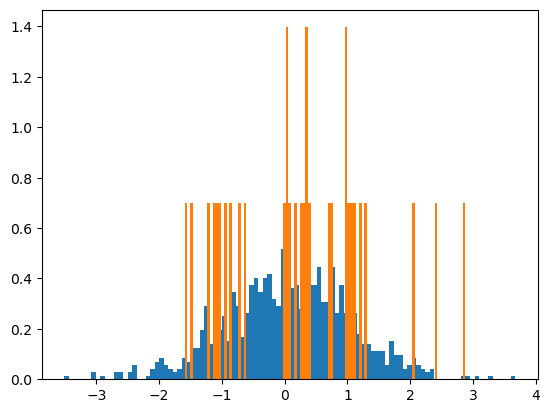

In [116]:
x_data_test = data_dist.sample([1000])
x_noise_test, traj_forward_test = diffusion.forward_sample(x_data_test)
plt.hist(x_noise_test.cpu(), bins = 100, density=True)
y_noise = traj_back[:, 0]
plt.hist(y_noise.cpu(), bins = 100, density=True)

AttributeError: Rectangle.set() got an unexpected keyword argument 'bin'

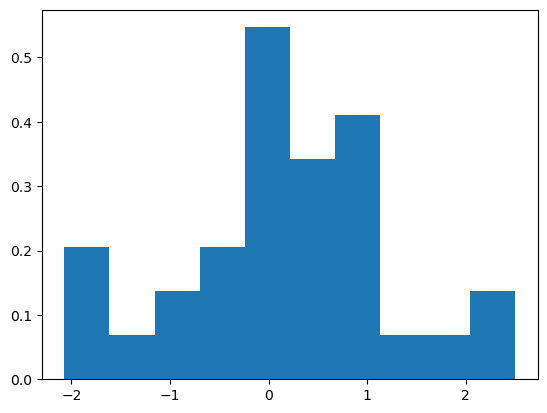

In [117]:
x_noise, traj_forward = diffusion.forward_sample(x_data)
traj_forward = traj_forward.to(device)
plt.hist(traj_forward[:, -1].cpu(), bin = 10,density = True) 
print(traj_forward_flip.shape)

# add the lead-lag transformation

In [118]:
def lead_lag_transform(x: torch.Tensor) -> torch.Tensor:
    """
    Lead-lag transformation for a multivariate paths.
    """
    x_rep = torch.repeat_interleave(x, repeats=2, dim=1)
    #print(x_rep.shape)
    x_ll = torch.cat([x_rep[:,  :-1], x_rep[:, 1:]], dim=2)
   # print(x_ll.shape)
    return x_ll


In [119]:
ll.apply(traj_forward.reshape([-1, 101, 1]))

tensor([[[-2.0437, -2.0437],
         [-2.0437, -2.0102],
         [-2.0102, -2.0102],
         ...,
         [ 0.2488,  0.2488],
         [ 0.2488, -0.1989],
         [-0.1989, -0.1989]],

        [[-1.6357, -1.6357],
         [-1.6357, -1.6460],
         [-1.6460, -1.6460],
         ...,
         [-0.6909, -0.6909],
         [-0.6909, -0.1228],
         [-0.1228, -0.1228]],

        [[-1.4757, -1.4757],
         [-1.4757, -1.4625],
         [-1.4625, -1.4625],
         ...,
         [-0.9042, -0.9042],
         [-0.9042, -1.2032],
         [-1.2032, -1.2032]],

        ...,

        [[-2.8382, -2.8382],
         [-2.8382, -2.8900],
         [-2.8900, -2.8900],
         ...,
         [ 2.6080,  2.6080],
         [ 2.6080,  2.5019],
         [ 2.5019,  2.5019]],

        [[ 2.5839,  2.5839],
         [ 2.5839,  2.5830],
         [ 2.5830,  2.5830],
         ...,
         [ 0.2397,  0.2397],
         [ 0.2397,  0.1030],
         [ 0.1030,  0.1030]],

        [[ 2.3570,  2.3570],
       

In [120]:
"""
Simple augmentations to enhance the capability of capturing important features in the first components of the
signature.
"""
from dataclasses import dataclass
from typing import List, Tuple

@dataclass
class BaseAugmentation:
    pass

    def apply(self, *args: List[torch.Tensor]) -> torch.Tensor:
        raise NotImplementedError('Needs to be implemented by child.')

@dataclass
class LeadLag(BaseAugmentation):
    with_time: bool = False

    def apply(self, x: torch.Tensor):
        if self.with_time:
            return lead_lag_transform_with_time(x)
        else:
            return lead_lag_transform(x)

def apply_augmentations(x: torch.Tensor, augmentations: Tuple) -> torch.Tensor:
    y = x.clone()
    for augmentation in augmentations:
        y = augmentation.apply(y)
    return y


In [121]:
ll = LeadLag()
t = traj_forward.view([-1, total_steps+1, 1])
a = ll.apply(t)

In [122]:
t = traj_forward_flip.view([-1, total_steps+1, 1])
print(t.shape)

torch.Size([32, 101, 1])


In [ ]:
pcf1 = PCF_with_empirical_measure(16, 10, 2, add_time=True)
pcf1 = pcf1.to(device)
num_paths = 32
G_opt = torch.optim.Adam(score_net.parameters(), lr=1e-4, betas=(0.9, 0.999))
D_opt = torch.optim.Adam(pcf.parameters(), lr=5e-3, betas=(0.9, 0.999))
n_Gstep_per_Dstep = 10
num_epochs = 50
for i in range(num_epochs):
    x_data = data_dist.sample([num_paths])
    x_noise, traj_forward = diffusion.forward_sample(x_data)
    traj_forward = traj_forward.to(device)
    traj_forward_flip = torch.fliplr(traj_forward)
             
    # train the PCF network as a discriminator. We want PCF has a great ablitily to distinguish the real data and the generated data. 
    # So we train the PCF to maxmise the distance between the real data and the generated data.
    with torch.no_grad():
        x_gen, traj_back = diffusion.backward_sample(torch.randn([num_paths, 1]).to(device), score_net)
        
        
    pcf1.train()
    D_loss = -pcf1.distance_measure(ll.apply(traj_forward_flip.view([-1, total_steps+1, 1])), ll.apply(traj_back.view([-1, total_steps+1, 1])), Lambda=0.0) 

    D_opt.zero_grad()
    D_loss.backward()
    D_opt.step()
    pcf1.eval()

    for j in range(n_Gstep_per_Dstep):
        with torch.no_grad():
            x_data = data_dist.sample([num_paths])
            x_noise, traj_forward = diffusion.forward_sample(x_data)
            traj_forward = traj_forward.to(device)
            x_gen, traj_back = diffusion.backward_sample(torch.randn([num_paths, 1]).to(device), score_net) 
        traj_forward_flip = torch.fliplr(traj_forward)
        G_loss =  pcf1.distance_measure(ll.apply(traj_forward_flip.view([-1, total_steps+1, 1])), 
                                ll.apply(traj_back.view([-1, total_steps+1, 1])), Lambda=0) 
        G_opt.zero_grad()
        G_loss.backward()
        G_opt.step()
        pcf1.eval()
        print(j, G_loss.item())
    
    print(i, D_loss.item(), G_loss.item())

0 0.6232668161392212
1 0.628649890422821
2 0.6151180863380432
3 0.633221447467804
4 0.6149716377258301
5 0.6375901699066162
6 0.6175711154937744
7 0.616300642490387
8 0.6497901678085327
9 0.646863579750061
0 -0.6227635145187378 0.646863579750061
0 0.6087530851364136
1 0.635704755783081
2 0.6198238134384155
3 0.6088724136352539
4 0.6049083471298218
5 0.6295987963676453
6 0.6194866299629211
7 0.6186439394950867
8 0.6297452449798584
9 0.6366113424301147
1 -0.638733983039856 0.6366113424301147
0 0.6157046556472778
1 0.6122426986694336
2 0.6065064668655396
3 0.6301498413085938
4 0.6116357445716858
5 0.6203347444534302
6 0.6056593656539917
7 0.6257275342941284
8 0.6331334114074707
9 0.6031652092933655
2 -0.6005828976631165 0.6031652092933655
0 0.6439836025238037
1 0.6202340126037598
2 0.620302677154541
3 0.6187905669212341
4 0.6768467426300049
5 0.6464754343032837
6 0.6257113218307495
7 0.6148619651794434
8 0.6133919954299927
9 0.6315302848815918
3 -0.6047184467315674 0.6315302848815918
0 0.

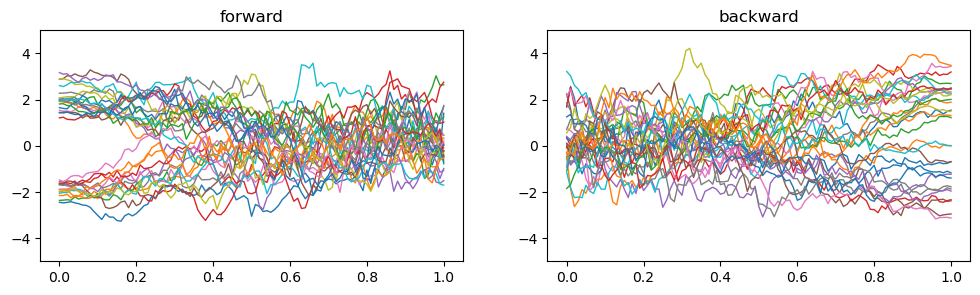

In [127]:
xxx = np.linspace(0, 1, traj_forward.shape[1])

plt.figure(figsize=(12,3))

plt.subplot(1, 2, 1)
for line in traj_forward:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('forward')
plt.ylim(-5, 5)
    
plt.subplot(1, 2, 2)
x_gen, traj_back = diffusion.sample(torch.randn([num_paths, 1]).to(device), score_net)


for line in traj_back:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('backward')
plt.ylim(-5, 5)

plt.show()